In [1]:
import os
import cv2
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC,Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras.applications import Xception,VGG19,ResNet50,InceptionResNetV2,ResNet152V2,EfficientNetB2,ConvNeXtTiny 
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,GlobalMaxPooling2D,Dropout
random.seed(555)

In [2]:
train=r"D:\IMARTICUS\Capstone project 2\casting_data\casting_data\train"
test=r"D:\IMARTICUS\Capstone project 2\casting_data\casting_data\test"

In [3]:
train_def=train + '/def_front/'
train_ok=train+'/ok_front/'

In [4]:
test_def=test+ '/def_front/'
test_ok=test+'/ok_front/'

In [5]:
img_train_ok=os.listdir(train_ok)
img_train_def=os.listdir(train_def)

In [6]:
len(img_train_ok)


2875

In [7]:
len(img_train_def)

3758

In [8]:
import matplotlib.pyplot as plt

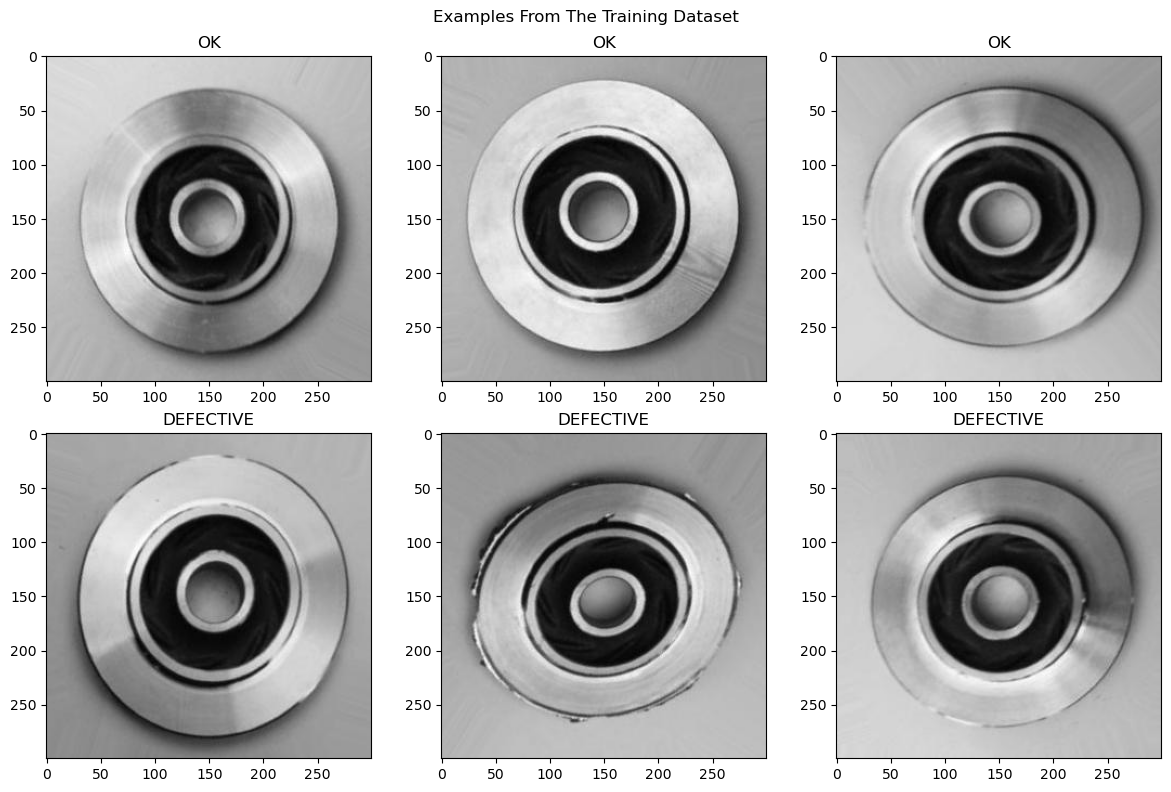

In [9]:
def get_random_images(d, num_files):
    files=os.listdir(d)
    random.shuffle(files)
    return files[:num_files]

plt.figure(figsize=(12,8))
plt.suptitle('Examples From The Training Dataset')

for i in range(3):
    plt.subplot(2,3,i+1)
    img_ok=get_random_images(train_ok,3)
    img=cv2.imread(os.path.join(train_ok,img_ok[i]))
    plt.imshow(img)
    plt.title('OK')
    
for i in range(3):
    plt.subplot(2,3,i+4)
    img_def=get_random_images(train_def,3)
    img=cv2.imread(os.path.join(train_def, img_def[i]))
    plt.imshow(img)
    plt.title('DEFECTIVE')
    
plt.tight_layout()
plt.show()

In [10]:
img=Image.open(os.path.join(train_def, img_train_def[0]))
img.size, img.mode

((300, 300), 'RGB')

In [11]:
img_ok=Image.open(os.path.join(train_ok, img_train_ok[0]))
img.size, img.mode

((300, 300), 'RGB')

In [12]:
traingen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    validation_split=0.2
)

testgen=ImageDataGenerator(rescale=1./255)

In [13]:
img_size = (300,300)
rand_seed = 555
batch_size = 32
epochs = 3

In [14]:
arg_train = {'target_size': img_size,
             'color_mode': 'rgb',
             'classes': {'ok_front': 0,
                         'def_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}

arg_test = {'target_size': img_size,
            'color_mode': 'rgb',
            'classes': {'ok_front': 0,
                        'def_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}

In [15]:
train_set=traingen.flow_from_directory(directory=train,
                                      subset='training',
                                      **arg_train)
validation_set=traingen.flow_from_directory(directory=train,subset='validation',
                                            **arg_train)
test_set=testgen.flow_from_directory(directory=test,**arg_test)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [16]:
from keras.applications import Xception, ResNet50, InceptionResNetV2, ResNet152V2
from keras.layers import GlobalMaxPooling2D, Dense
from keras.models import Model
from keras.regularizers import L1L2
from keras.optimizers import Adam
from keras.metrics import AUC, Precision, Recall

# Load the pretrained model based on model_name
def load_pretrained_model(model_name):
    if model_name == 'Xception':
        return Xception(weights='imagenet', include_top=False)
    elif model_name == 'ResNet50':
        return ResNet50(weights='imagenet', include_top=False)
    elif model_name == 'InceptionResNetV2':
        return InceptionResNetV2(weights='imagenet', include_top=False)
    elif model_name == 'ResNet152V2':
        return ResNet152V2(weights='imagenet', include_top=False)

# Create and compile model with the base_model
def create_and_compile_model(base_model, learning_rate=0.01):
    # Add pooling and dense layers to the base model
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=L1L2(l1=0.01, l2=0.01))(x)
    x = Dense(128, activation='relu', kernel_regularizer=L1L2(l1=0.01, l2=0.01))(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

    # Create a new model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(), Precision(), Recall()])

    return model

In [17]:
def train_and_evaluate_model(model, model_name, train_set, valid_set, test_set, epochs=10, batch_size=32):
    model_checkpoint = ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_auc',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )
    
    # Start the timer
    start_time = time.time()

    history = model.fit(
        train_set,
        steps_per_epoch=train_set.samples // batch_size,
        epochs=epochs,
        validation_data=valid_set,
        validation_steps=valid_set.samples // batch_size,
        callbacks=[model_checkpoint]
    )

    # End the timer
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model on the test set
    test_loss, *test_metrics = model.evaluate(test_set, steps=test_set.samples // batch_size)
    test_acc = test_metrics[0]
    test_auc = test_metrics[1]
    test_precision = test_metrics[2]
    test_recall = test_metrics[3]

    # Start the evaluation timer
    evaluation_time = time.time() - end_time

    # Print the results
    print(f"model: {model_name}")
    print(f"Test accuracy: {test_acc * 100:.2f}%")
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Evaluation time: {evaluation_time:.2f} seconds")
    
    y_true = test_set.classes
    y_pred = model.predict(test_set)
    y_pred_classes = (y_pred > 0.5).astype(int)  # Convert to 0 or 1 based on a threshold
    cm = confusion_matrix(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes)
    auc = roc_auc_score(y_true, y_pred)

    return test_acc, cm, report, auc, test_precision, test_recall, history.history

In [18]:
%%time

#model_names = ['Xception', 'InceptionResNetV2', 'ResNet152V2']
model_names = ['ResNet152V2']
results = {}

for model_name in model_names:
    print(f"Training model: {model_name}")
    base_model = load_pretrained_model(model_name)
    model = create_and_compile_model(base_model)
    test_acc, cm, report, auc, precision, recall, history = train_and_evaluate_model(model,
                                                         model_name,
                                                         train_set,
                                                         validation_set,
                                                         test_set,
                                                         epochs,
                                                         batch_size)
    
    results[model_name] = {
        'test_accuracy': test_acc,
        'confusion_matrix': cm,
        'classification_report': report,
        'roc_auc': auc,
        'history': history}

Training model: ResNet152V2
Epoch 1/3


C:\Users\Munirajesh\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7254 - auc: 0.7524 - loss: 49.3162 - precision: 0.7610 - recall: 0.7573 
Epoch 1: val_auc improved from -inf to 0.99161, saving model to best_model.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 2233s 13s/step - accuracy: 0.7260 - auc: 0.7531 - loss: 49.1596 - precision: 0.7614 - recall: 0.7578 - val_accuracy: 0.9619 - val_auc: 0.9916 - val_loss: 8.7545 - val_precision: 0.9727 - val_recall: 0.9596
Epoch 2/3
  1/165 ━━━━━━━━━━━━━━━━━━━━ 32:54 12s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 8.7009 - precision: 1.0000 - recall: 1.0000

C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_auc improved from 0.99161 to 1.00000, saving model to best_model.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 8.7009 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 8.6756 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/3
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9135 - auc: 0.9709 - loss: 7.9711 - precision: 0.9359 - recall: 0.9073 
Epoch 3: val_auc did not improve from 1.00000
165/165 ━━━━━━━━━━━━━━━━━━━━ 2440s 15s/step - accuracy: 0.9135 - auc: 0.9709 - loss: 7.9676 - precision: 0.9359 - recall: 0.9074 - val_accuracy: 0.8537 - val_auc: 0.9946 - val_loss: 6.5592 - val_precision: 0.7981 - val_recall: 0.9933
22/22 ━━━━━━━━━━━━━━━━━━━━ 222s 10s/step - accuracy: 0.8189 - auc: 0.6504 - loss: 6.6563 - precision: 0.4707 - recall: 0.6522
model: ResNet152V2
Test accuracy: 90.34%
Test loss: 6.4858
Test AUC: 0.9977
Test Precision: 0.8667
Test Recall: 1.0000
Training time: 4697.

Best Model: ResNet152V2
Test Accuracy: 90.34%
Confusion Matrix:
[[194  68]
 [  0 453]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85       262
           1       0.87      1.00      0.93       453

    accuracy                           0.90       715
   macro avg       0.93      0.87      0.89       715
weighted avg       0.92      0.90      0.90       715

ROC AUC: 1.00


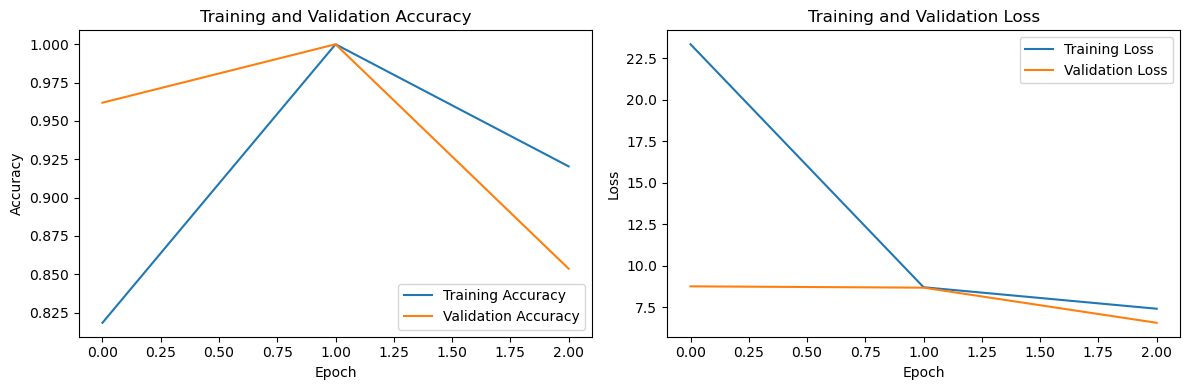

In [19]:
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model_results = results[best_model_name]

# Access the performance metrics
best_test_acc = best_model_results['test_accuracy']
best_cm = best_model_results['confusion_matrix']
best_report = best_model_results['classification_report']
best_auc = best_model_results['roc_auc']
best_history = best_model_results['history']

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {best_test_acc * 100:.2f}%")
print("Confusion Matrix:")
print(best_cm)
print("Classification Report:")
print(best_report)
print(f"ROC AUC: {best_auc:.2f}")

# Plot training and validation accuracy and loss

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_history['accuracy'], label='Training Accuracy')
plt.plot(best_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
model.save('be.h5')

In [22]:
# Load the saved model
best_model = load_model('be.h5')
# Assuming you have set up the 'test_set' as mentioned earlier
predictions = best_model.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
true_labels = test_set.classes

# Calculate classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
conf_matrix = confusion_matrix(true_labels, predicted_labels)

23/23 ━━━━━━━━━━━━━━━━━━━━ 280s 12s/step
              precision    recall  f1-score   support

           0       1.00      0.74      0.85       262
           1       0.87      1.00      0.93       453

    accuracy                           0.90       715
   macro avg       0.93      0.87      0.89       715
weighted avg       0.92      0.90      0.90       715



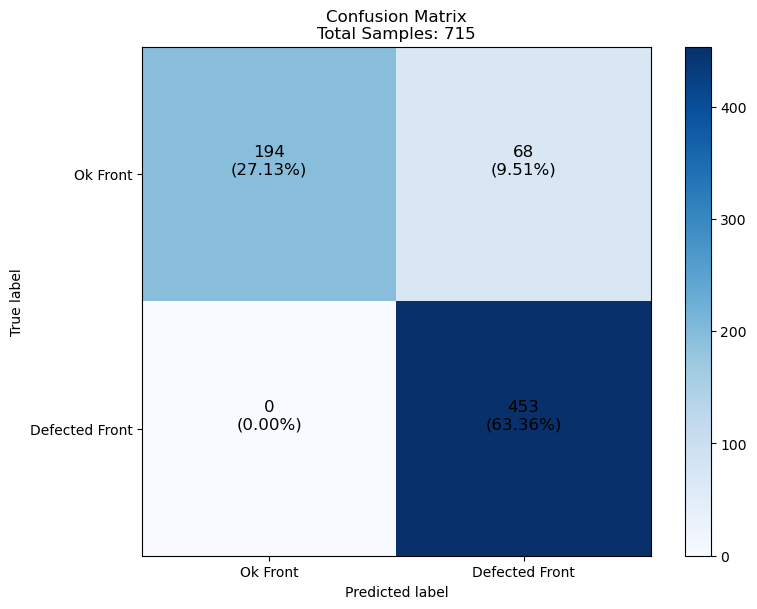

In [23]:
total_samples = np.sum(conf_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title(f'Confusion Matrix\nTotal Samples: {total_samples}')
plt.colorbar()
tick_marks = np.arange(2)  # Assuming you have 2 classes (0 and 1)
plt.xticks(tick_marks, ['Ok Front', 'Defected Front'])
plt.yticks(tick_marks, ['Ok Front', 'Defected Front'])/
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add numbers inside the boxes with black color and percentages
for i in range(2):
    for j in range(2):
        count = conf_matrix[i, j]
        percentage = (count / total_samples) * 100
        plt.text(j, i, f'{count}\n({percentage:.2f}%)', horizontalalignment='center', color='black', fontsize=12)

plt.show()

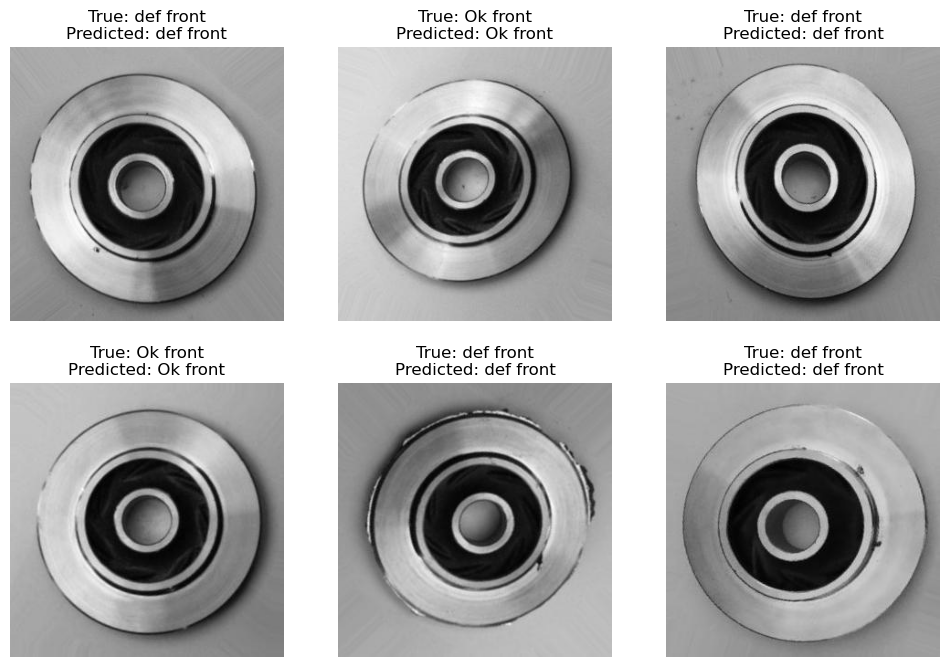

In [24]:
num_samples_to_display = 6
nbr_samples_every_row = 3
rows = num_samples_to_display // nbr_samples_every_row
random.seed(33)

total_samples = len(test_set.filenames)

# Generate random indices to select random samples
random_indices = random.sample(range(total_samples), num_samples_to_display)

# Initialize a list to store the selected images, true labels, and predicted labels
random_sample_data = []

# Extract the random images, true labels, and predicted labels
for idx in random_indices:
    image_path = test_set.filepaths[idx]
    true_label = test_set.classes[idx]
    image = plt.imread(image_path)
    predicted_label = predicted_labels[idx]
    true_label_text = "def front" if true_label == 1 else "Ok front"
    predicted_label_text = "def front" if predicted_label == 1 else "Ok front"
    random_sample_data.append((image, true_label_text, predicted_label_text))

# Visualize the random sample images with true and predicted labels
plt.figure(figsize=(12, 8))
for i, (image, true_label_text, predicted_label_text) in enumerate(random_sample_data):
    plt.subplot(rows, nbr_samples_every_row, i + 1)
    plt.imshow(image)
    plt.title(f'True: {true_label_text}\nPredicted: {predicted_label_text}')
    plt.axis('off')
plt.show()